Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB

Missing Values:
text    0
spam    0
dtype: int64
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1063
           1       0.99      0.88      0.93       369

    accuracy                           0.97      1432
   macro avg       0.97      0.94      0.95      1432
weighted avg       0.97      0.97      0.97      1432

Confusion Matrix:


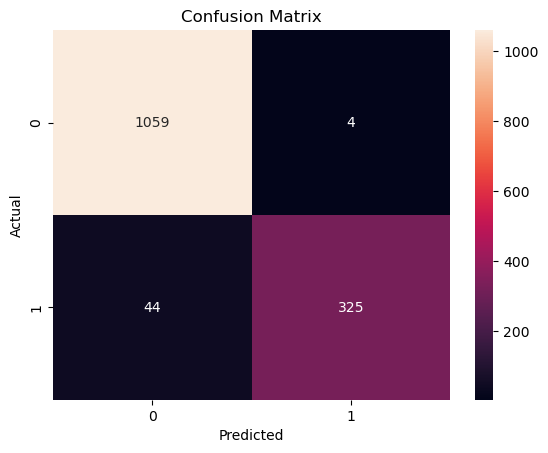

Accuracy: 96.65%


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import Pl./orterStemmer
import string
import re
import nltk

# Download NLTK data files
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


# Load dataset
data = pd.read_csv(r'C:\Users\KIIT\Documents\Jupyter Notebook\EmailSpam_Detection\email-classification-flask-main\emails.csv')

# Display basic information
print("Dataset Overview:")
data.info()

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Preprocessing Function
def preprocess_text(text):
    text = str(text).lower()  # Lowercase and handle NaN
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]  # Stemming
    return " ".join(tokens)

# Apply preprocessing to email body
data['Processed_Body'] = data['text'].apply(preprocess_text)

# Extract Subject from text column
def extract_subject(text):
    text = str(text)
    if text.startswith("Subject:"):
        return text[8:].split('\n')[0]  # Extract subject and remove newline
    else:
        return ""  # Return empty string if no subject

data['Subject'] = data['text'].apply(extract_subject)

# Analyze subject lines and sender information for feature extraction
data['Subject'] = data['Subject'].fillna('')  # Fill NaN values in 'Subject'
data['Subject_Length'] = data['Subject'].apply(lambda x: len(str(x)))

# Extract From (Sender) from text column
def extract_sender(text):
    text = str(text)
    # Basic extraction - improve as needed
    match = re.search(r"[\w\.-]+@[\w\.-]+", text)
    if match:
        return match.group(0)
    else:
        return ""


data['From'] = data['text'].apply(extract_sender) # Extract sender from text
data['From'] = data['From'].fillna('')
data['Sender_Importance'] = data['From'].apply(lambda x: 1 if 'admin' in str(x).lower() or 'support' in str(x).lower() else 0)

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(data['Processed_Body']).toarray()

# Combine features
X_combined = np.hstack((X, data[['Subject_Length', 'Sender_Importance']].values))

# Target variable
y = data['spam']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Train a Naive Bayes model
model = MultinomialNB()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")



In [2]:
# Real-time prediction function
def classify_email(email_subject, email_body, email_sender):
    processed_body = preprocess_text(email_body)
    vectorized_body = vectorizer.transform([processed_body]).toarray()
    subject_length = len(str(email_subject))
    sender_importance = 1 if 'admin' in str(email_sender).lower() or 'support' in str(email_sender).lower() else 0
    combined_features = np.hstack((vectorized_body, [[subject_length, sender_importance]]))
    prediction = model.predict(combined_features)
    return "Spam" if prediction[0] == 1 else "Not Spam"



In [3]:
# Example real-time prediction
email_subject = input("Enter the email subject: ")
email_body = input("Enter the email body: ")
email_sender = input("Enter the email sender: ")
print(f"Prediction: {classify_email(email_subject, email_body, email_sender)}")


Enter the email subject:  Urgent: Your Account is Suspended!  
Enter the email body:  Dear Customer,    We have detected suspicious activity on your bank account. Please verify your identity immediately by clicking the link below:    [Click Here to Verify](http://fakebank.com/login)    Failure to do so will result in your account being locked.    Regards,   Bank Security Team 
Enter the email sender:  security@bankalerts.com 


Prediction: Spam
